In [499]:
import sys

sys.path.append('/home/caihuaiguang/DSG/pytorch-shapley-cam')

# 验证路径是否已添加
print(sys.path)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  

import torch
# 设置设备为GPU或CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

['/media/caihuaiguang/miniconda3/envs/cfr/lib/python38.zip', '/media/caihuaiguang/miniconda3/envs/cfr/lib/python3.8', '/media/caihuaiguang/miniconda3/envs/cfr/lib/python3.8/lib-dynload', '', '/media/caihuaiguang/miniconda3/envs/cfr/lib/python3.8/site-packages', '/home/caihuaiguang/PIDCFR', '/home/caihuaiguang/PIDCFR/third_party/PokerRL', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaiguang/DSG/pytorch-shapley-cam', '/home/caihuaigu

In [500]:
# import warnings
# warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
# import timm
import cv2
from torchvision import transforms
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
from pytorch_grad_cam.metrics.road import ROADLeastRelevantFirstAverage, ROADMostRelevantFirstAverage
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget, ClassifierOutputLnSoftmaxTarget, ClassifierOutputExclusiveLnSoftmaxTarget, ClassifierOutputReST, ClassifierOutputEntropy
from pytorch_grad_cam.ablation_layer import AblationLayerVit
from pytorch_grad_cam.metrics.ADCC import ADCC
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenGradCAM, LayerCAM, AblationCAM, RandomCAM, ShapleyCAM, ShapleyCAM_x, ShapleyCAM_mean, ShapleyCAM_hires, GradCAMElementWise, HiResCAM, XGradCAM


In [501]:
# # selet the layer before adaptive avg pooling, i.e., norm
# def reshape_transform(result, height=7, width=7):
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

# model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
# # target_layers = [model.layers[-1].blocks[-1].norm1]
# target_layers = [model.norm]

In [502]:
# def reshape_transform(result, height=7, width=7):
#     # print(result.shape)
#     result = result.reshape(result.size(0),
#                             height, width, result.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

# model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
# target_layers = [model.layers[-1].blocks[-1].norm2]

In [503]:
# # vit performance is not good
# import torch
# def reshape_transform(tensor, height=14, width=14):
#     # print(tensor.shape)
#     result = tensor[:, 1:, :].reshape(tensor.size(0),
#                                       height, width, tensor.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result
# model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

# target_layers =  [model.blocks[-1].norm1]
# # target_layers =  [model.blocks[-1].norm2]
# # target_layers =  [model.norm]

In [504]:

# model = models.resnet152(pretrained=True)
# reshape_transform = None
# # target_layers = [model.layer4[-1].conv3]
# target_layers = [model.layer4[-1].relu]

In [505]:

# model = models.vgg16(pretrained=True)
# reshape_transform = None
# target_layers = [model.features[-1]]

In [506]:

# model = models.efficientnet_b0(pretrained=True)
# reshape_transform = None
# target_layers = [model.features[8][2]]

In [507]:

model = models.resnet18(pretrained=True)
reshape_transform = None
# target_layers = [model.layer4[-1].conv2]
target_layers = [model.layer4[-1]]

In [508]:

# model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
# reshape_transform = None
# target_layers = [model.features[-1][0]]

In [509]:
model.eval()
model = model.cuda()

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, name, adcc):
    if name is not None:
        visualization = cv2.putText(visualization, name, (5, 20), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    if adcc is not None:
        visualization = cv2.putText(visualization, f"{adcc:.5f}", (150, 20), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(_img_example, _img_name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=None):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("HiResCAM", HiResCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("LayerCAM", LayerCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("GradCAM-E", GradCAMElementWise(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("ScoreCAM", ScoreCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("XGradCAM", XGradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("ShapleyCAM-E", ShapleyCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("ShapleyCAM-M", ShapleyCAM_mean(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("ShapleyCAM-H", ShapleyCAM_hires(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("ShapleyCAM-X", ShapleyCAM_x(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            # #    ("AblationCAM", AblationCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform, ablation_layer=AblationLayerVit())),
            #    ("RandomCAM", RandomCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ]

    cam_metric = ADCC()
    # targets = [ClassifierOutputTarget(category)]
    # targets = [ClassifierOutputSoftmaxTarget(category)]
    # targets = [ClassifierOutputLnSoftmaxTarget(category)]
    # targets = [ClassifierOutputExclusiveLnSoftmaxTarget(category)]
    targets = [ClassifierOutputReST(category)]
    # targets = [ClassifierOutputEntropy(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = [visualize_score(np.uint8(255 * _img_example), _img_name, None,)]
    for name, cam_method in methods:
        attributions = cam_method(input_tensor=input_tensor, 
                                    targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]   
        adcc, avg_drop, coherency, complexity, inc, dropindeletion   =cam_metric(input_tensor,attributions,targets,metric_targets,model, cam_method)
        visualization = show_cam_on_image(_img_example, attribution, use_rgb=True)
        visualization = visualize_score(visualization, name, adcc[0] )
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))


In [510]:
# import torch
# from torchvision import datasets, transforms, models
# from torch.utils.data import DataLoader
# import timm
# from tqdm import tqdm


# # 标准的ImageNet图像预处理
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # 加载ImageNet验证集
# val_dataset = datasets.ImageFolder('/media/caihuaiguang/data/ILSVRC2012_img_val', transform=transform)
# val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

# model = model.to(device)
# model.eval()

# # 初始化统计变量
# correct = 0
# total = 0

# # 迭代验证集进行预测
# with torch.no_grad():
#     for batch_idx, (imgs, labels) in enumerate(tqdm(val_loader, desc="Processing images", unit="batch")):
#         if batch_idx == 6:
#             break
#         imgs = imgs.to(device)
#         labels = labels.to(device)
        
#         # 模型推理
#         outputs = model(imgs)
#         _, predicted = torch.max(outputs.data, 1)
        
#         # 统计准确数量
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
        
#         # 查找错误预测的文件名
#         batch_start_idx = batch_idx * val_loader.batch_size  # 当前批次在数据集中起始的索引
#         for i in range(len(predicted)):
#             if predicted[i] != labels[i]:  # 预测错误时
#                 # 获取当前样本的文件路径
#                 file_path = val_dataset.samples[batch_start_idx + i][0]
#                 print(f"Misclassified: {file_path}, Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")

# # 计算并打印准确率
# accuracy = 100 * correct / total
# print(f'Accuracy on the ImageNet validation set: {accuracy:.2f}%')


In [511]:
# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
# using this link to get label name from ID (start from 0) 

In [512]:
# img_path = "./pic/ILSVRC2012_val_00023935.JPEG"  
img_path = "./pic/ILSVRC2012_val_00035405.JPEG"
name = "tiger shark"
img = np.array(Image.open(img_path)) # true:3, pridict 4
img = np.array(Image.fromarray(img).resize((224, 224)))
img = np.float32(img) / 255
transform = transforms.Compose([
    transforms.Resize(256),  # 调整图像大小为 256x256
    transforms.CenterCrop(224),  # 中心裁剪为 224x224
    transforms.ToTensor(),  # 转换为 Tensor，并将像素值归一化到 [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 加载图像
img_tensor = Image.open(img_path).convert('RGB')  # 转换为 RGB 图像
input_tensor = transform(img_tensor)
# 增加批次维度 (batch size = 1)，即 (1, 3, 224, 224)
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.cuda() 

model.eval()
outputs = model(input_tensor)
_, predicted = torch.max(outputs.data, 1)
_, predicted_min = torch.min(outputs.data, 1)
print(predicted) # 2: great white shark
print(predicted_min) # 90: lorikeet

np.random.seed(42)

tensor([4], device='cuda:0')
tensor([70], device='cuda:0')


In [513]:
outputs = torch.softmax(outputs,dim=1)

In [514]:

# 获取前5个最高概率的标签及其对应的索引
top5_probs, top5_indices = torch.topk(outputs, 5, dim=1)

# 获取前5个最低概率的标签及其对应的索引
bottom5_probs, bottom5_indices = torch.topk(outputs, 5, dim=1, largest=False)

# 打印前5个最高概率的标签和对应概率
print("Top 5 labels and probabilities for each example:")
for i in range(outputs.size(0)): 
    for j in range(5):
        print(f"Label: {top5_indices[i][j].item()}, Probability: {top5_probs[i][j].item()}")

# 打印前5个最低概率的标签和对应概率
print("\nLowest 5 labels and probabilities for each example:")
for i in range(outputs.size(0)): 
    for j in range(5):
        print(f"Label: {bottom5_indices[i][j].item()}, Probability: {bottom5_probs[i][j].item()}")

Top 5 labels and probabilities for each example:
Label: 4, Probability: 0.3845239281654358
Label: 3, Probability: 0.36629998683929443
Label: 983, Probability: 0.09040933847427368
Label: 149, Probability: 0.06800241023302078
Label: 2, Probability: 0.032922349870204926

Lowest 5 labels and probabilities for each example:
Label: 70, Probability: 1.413609784783887e-10
Label: 640, Probability: 1.6927635682062458e-10
Label: 91, Probability: 1.9579664278790432e-10
Label: 200, Probability: 2.0226173513826495e-10
Label: 214, Probability: 2.0489628049791264e-10


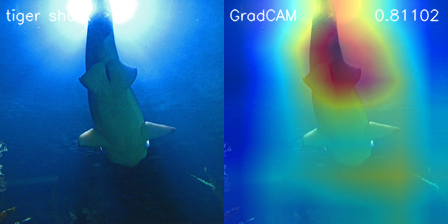

In [515]:

category = top5_indices[0][0] #  label is 3 (tiger shark), but resnet18 think it is 2 (great white shark)
benchmark(img, name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

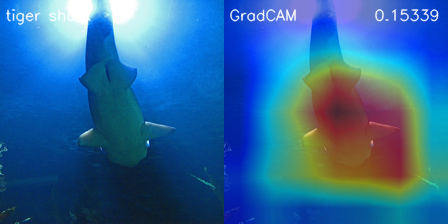

In [516]:
category = top5_indices[0][1] #  label is 3(tiger shark), but resnet18 think it is 2(great white shark)
benchmark(img, name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

In [517]:
img_path = "./pic/ILSVRC2012_val_00031424.JPEG" # true: 4
name = "hammerhead"
img = np.array(Image.open(img_path)) 
img = np.array(Image.fromarray(img).resize((224, 224)))
img = np.float32(img) / 255
transform = transforms.Compose([
    transforms.Resize(256),  # 调整图像大小为 256x256
    transforms.CenterCrop(224),  # 中心裁剪为 224x224
    transforms.ToTensor(),  # 转换为 Tensor，并将像素值归一化到 [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 加载图像
img_tensor = Image.open(img_path).convert('RGB')  # 转换为 RGB 图像
input_tensor = transform(img_tensor)
# 增加批次维度 (batch size = 1)，即 (1, 3, 224, 224)
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.cuda() 

model.eval()
outputs = model(input_tensor)
_, predicted = torch.max(outputs.data, 1)
_, predicted_min = torch.min(outputs.data, 1)
print(predicted) # 2: great white shark
print(predicted_min) # 90: lorikeet

np.random.seed(42)

tensor([4], device='cuda:0')
tensor([547], device='cuda:0')


In [518]:
outputs = torch.softmax(outputs,dim=1)

In [519]:

# 获取前5个最高概率的标签及其对应的索引
top5_probs, top5_indices = torch.topk(outputs, 5, dim=1)

# 获取前5个最低概率的标签及其对应的索引
bottom5_probs, bottom5_indices = torch.topk(outputs, 5, dim=1, largest=False)

# 打印前5个最高概率的标签和对应概率
print("Top 5 labels and probabilities for each example:")
for i in range(outputs.size(0)): 
    for j in range(5):
        print(f"Label: {top5_indices[i][j].item()}, Probability: {top5_probs[i][j].item()}")

# 打印前5个最低概率的标签和对应概率
print("\nLowest 5 labels and probabilities for each example:")
for i in range(outputs.size(0)): 
    for j in range(5):
        print(f"Label: {bottom5_indices[i][j].item()}, Probability: {bottom5_probs[i][j].item()}")

Top 5 labels and probabilities for each example:
Label: 4, Probability: 0.9985578656196594
Label: 2, Probability: 0.0010552832391113043
Label: 3, Probability: 0.0003151318815071136
Label: 327, Probability: 2.4924480385379866e-05
Label: 5, Probability: 1.480837363487808e-05

Lowest 5 labels and probabilities for each example:
Label: 547, Probability: 2.3555038128342254e-12
Label: 91, Probability: 2.551457959840131e-12
Label: 275, Probability: 2.977567628223432e-12
Label: 90, Probability: 3.2757492465090854e-12
Label: 603, Probability: 4.020726026426891e-12


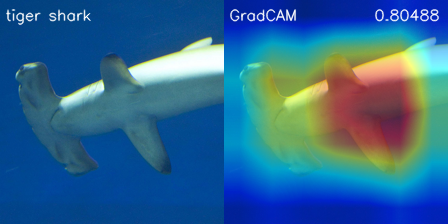

In [520]:

category = top5_indices[0][0] #  label is 3 (tiger shark), but resnet18 think it is 2 (great white shark)
benchmark(img, name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

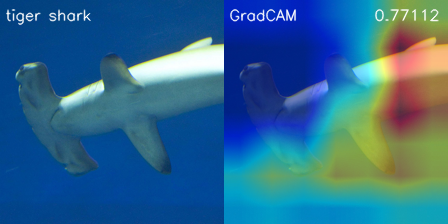

In [521]:
category = top5_indices[0][1] #  label is 3(tiger shark), but resnet18 think it is 2(great white shark)
benchmark(img, name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

In [522]:

img_path = "./pic/ILSVRC2012_val_00025969.JPEG" # true: 3
name = "tiger shark"
img = np.array(Image.open(img_path)) 
img = np.array(Image.fromarray(img).resize((224, 224)))
img = np.float32(img) / 255
transform = transforms.Compose([
    transforms.Resize(256),  # 调整图像大小为 256x256
    transforms.CenterCrop(224),  # 中心裁剪为 224x224
    transforms.ToTensor(),  # 转换为 Tensor，并将像素值归一化到 [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 加载图像
img_tensor = Image.open(img_path).convert('RGB')  # 转换为 RGB 图像
input_tensor = transform(img_tensor)
# 增加批次维度 (batch size = 1)，即 (1, 3, 224, 224)
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.cuda() 

model.eval()
outputs = model(input_tensor)
_, predicted = torch.max(outputs.data, 1)
_, predicted_min = torch.min(outputs.data, 1)
print(predicted) # 2: great white shark
print(predicted_min) # 90: lorikeet

np.random.seed(42)

tensor([3], device='cuda:0')
tensor([307], device='cuda:0')


In [523]:
outputs = torch.softmax(outputs,dim=1)

In [524]:

# 获取前5个最高概率的标签及其对应的索引
top5_probs, top5_indices = torch.topk(outputs, 5, dim=1)

# 获取前5个最低概率的标签及其对应的索引
bottom5_probs, bottom5_indices = torch.topk(outputs, 5, dim=1, largest=False)

# 打印前5个最高概率的标签和对应概率
print("Top 5 labels and probabilities for each example:")
for i in range(outputs.size(0)): 
    for j in range(5):
        print(f"Label: {top5_indices[i][j].item()}, Probability: {top5_probs[i][j].item()}")

# 打印前5个最低概率的标签和对应概率
print("\nLowest 5 labels and probabilities for each example:")
for i in range(outputs.size(0)): 
    for j in range(5):
        print(f"Label: {bottom5_indices[i][j].item()}, Probability: {bottom5_probs[i][j].item()}")

Top 5 labels and probabilities for each example:
Label: 3, Probability: 0.7977654933929443
Label: 2, Probability: 0.20162822306156158
Label: 4, Probability: 0.0004117817443329841
Label: 148, Probability: 0.00011188557982677594
Label: 149, Probability: 4.269723649485968e-05

Lowest 5 labels and probabilities for each example:
Label: 307, Probability: 7.443001856696481e-16
Label: 305, Probability: 1.4839830888646946e-15
Label: 262, Probability: 2.245957199313955e-15
Label: 304, Probability: 3.1226187237885002e-15
Label: 522, Probability: 3.92609554282909e-15


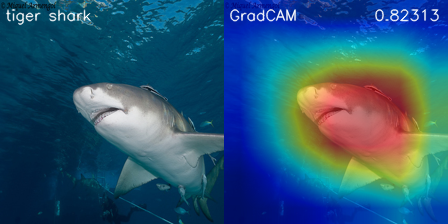

In [525]:
category = top5_indices[0][0] #  label is 3 (tiger shark), but resnet18 think it is 2 (great white shark)
benchmark(img, name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

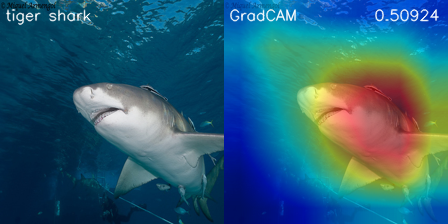

In [526]:
category = top5_indices[0][1] #  label is 3(tiger shark), but resnet18 think it is 2(great white shark)
benchmark(img, name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)